In [1]:
import numpy
import matplotlib

# http://bkanuka.com/articles/native-latex-plots/
def figsize(scale):
    fig_width_pt = 240.0
    inches_per_pt = 1.0/72.27
    golden_mean = (numpy.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt*inches_per_pt*scale
    fig_height = fig_width*golden_mean
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": [],
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": figsize(0.9),
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",
        r"\usepackage[T1]{fontenc}",
    ]
}
matplotlib.rcParams.update(pgf_with_latex)


In [2]:
import collections
import copy
import itertools
import logging
import re

import astropy.io.ascii
import matplotlib.pyplot as plt
%matplotlib inline
import numpy
import scipy.spatial

import pipeline

log = logging.getLogger(__name__)

titlemap = {
    'RGZ & Norris & compact': 'Compact',
    'RGZ & Norris & resolved': 'Resolved',
    'RGZ & Norris': 'All',
    'RGZ & compact': 'Compact',
    'RGZ & resolved': 'Resolved',
    'RGZ': 'All',
}

fullmap = {
    'RGZ & Norris & compact': 'RGZ & compact',
    'RGZ & Norris & resolved': 'RGZ & resolved',
    'RGZ & Norris': 'RGZ',
}

whatset = {
    'RGZ & Norris & compact': 'RGZ & Norris & compact',
    'RGZ & Norris & resolved': 'RGZ & Norris & resolved',
    'RGZ & Norris': 'RGZ & Norris',
    'RGZ & compact': 'RGZ & Norris & compact',
    'RGZ & resolved': 'RGZ & Norris & resolved',
    'RGZ': 'RGZ & Norris',
}

norris_labelled_sets = [
    'RGZ & Norris & compact',
    'RGZ & Norris & resolved',
    'RGZ & Norris',
]

field = 'elais'
log.debug('Getting SWIRE, ATLAS features.')
swire_names, swire_coords, _ = pipeline.generate_swire_features(overwrite=False, field=field)
swire_labels = pipeline.generate_swire_labels(swire_names, swire_coords, overwrite=False, field=field)
(_, atlas_test_sets), (_, swire_test_sets) = pipeline.generate_data_sets(swire_coords, swire_labels, overwrite=False, field=field)
log.debug('Calling cross-identify.')
cids = list(pipeline.cross_identify_all(swire_names, swire_coords, swire_labels, swire_test_sets, swire_labels[:, 0], field=field))

# Also load the nearest-neighbour cross-identifications.
cids += [pipeline.CrossIdentifications.from_hdf5(
    pipeline.WORKING_DIR + 'NearestNeighbour_{}_cross_ids_{}_RGZ & Norris.h5'.format(field, q)) for q in range(4 if field == 'cdfs' else 1)]

swire_tree = scipy.spatial.KDTree(swire_coords[swire_test_sets[:, 0, 0]])

failed_coords = []

if field == 'cdfs':
    table = astropy.io.ascii.read(pipeline.TABLE_PATH)
    rgzcat = astropy.io.ascii.read(pipeline.RGZ_PATH)

    atlas_to_swire_expert = {}
    atlas_to_swire_rgz = {}
    key_to_atlas = {}
    atlas_id_to_name = {}
    is_compact = {}
    for row in table:
        name = row['Component Name (Franzen)']
        key_to_atlas[row['Key']] = name
        swire = row['Source SWIRE (Norris)']
        if not swire or not swire.startswith('SWIRE') or not name:
            continue
        atlas_id_to_name[row['Component ID (Franzen)']] = name
        atlas_to_swire_expert[name] = swire
        is_compact[name] = pipeline.compact_test(row)
    for row in rgzcat:
        swire_name = row['SWIRE.designation']
        if not swire_name or swire_name == '-99':
            continue
        name = atlas_id_to_name.get(row['atlas_id'], None)
        atlas_to_swire_rgz[name] = swire_name
else:
    atlas_to_swire_expert = {}
    with astropy.io.fits.open(pipeline.MIDDELBERG_TABLE4_PATH) as elais_components_fits:
        elais_components = elais_components_fits[1].data
        atlas_cid_to_name = {}
        atlas_names = []  # Indices correspond to table 4 rows.
        atlas_name_to_compact = {}
        for component in elais_components:
            cid = component['CID']
            name = component['ATELAIS']
            atlas_names.append(name)
            atlas_cid_to_name[cid] = name
            row = {'Component S (Franzen)': component['Sint'],  # Fitting in with the CDFS API...
                   'Component S_ERR (Franzen)': component['e_Sint'],
                   'Component Sp (Franzen)': component['Sp'],
                   'Component Sp_ERR (Franzen)': component['e_Sp']}
            atlas_name_to_compact[name] = pipeline.compact_test(row)
    with open(pipeline.MIDDELBERG_TABLE5_PATH) as elais_file:
        # Took this code from pipeline.py, probably should make it a function
        lines = [line.split('|') for line in elais_file]
        for line in lines:
            if 'ATELAISJ' not in line[0]:
                continue

            line_cids = line[1]
            if 'C0' not in line_cids and 'C1' not in line_cids:
                continue

            line_cids = [cid.strip() for cid in line_cids.split(',')]
            swire_coord_re = re.search(r'SWIRE4J(\d\d)(\d\d)(\d\d\.\d\d)(-\d\d)(\d\d)(\d\d\.\d)', line[2])
            if not swire_coord_re:
                continue
            swire_coord_list = swire_coord_re.groups()
            coord = astropy.coordinates.SkyCoord(
                ra='{} {} {}'.format(*swire_coord_list[:3]),
                dec='{} {} {}'.format(*swire_coord_list[3:]),
                unit=('hourangle', 'deg'))
            coord = (coord.ra.deg, coord.dec.deg)
            # Nearest SWIRE...
            dist, nearest = swire_tree.query(coord)
            if dist > 5 / 60 / 60:
                logging.debug('No SWIRE match found for Middelberg cross-identification {}'.format(line[0]))
                logging.debug('Nearest is {} ({:.01f} arcsec)'.format(numpy.array(swire_names)[swire_test_sets[:, 0, 0]][nearest], dist * 60 * 60))
                logging.debug('Middelberg: {}'.format(swire_coord_re.group()))
                failed_coords.append(coord)
                continue
            name = numpy.array(swire_names)[swire_test_sets[:, 0, 0]][nearest]
            for cid in line_cids:
                atlas_to_swire_expert[atlas_cid_to_name[cid]] = name

labeller_classifier_to_accuracies = collections.defaultdict(list)

# Augment the CIDs by duplicating the "resolved" cross-ids to make the "all" set.
resolved_cids_copy = [copy.copy(cid) for cid in cids if 'resolved' in cid.dataset_name]
for cid in resolved_cids_copy:
    cid.dataset_name = cid.dataset_name.replace(' & resolved', '')
cids.extend(resolved_cids_copy)

for cid in cids:
    if cid.labeller == 'norris' and 'Norris' not in cid.dataset_name:
        continue

    if cid.classifier in {'Groundtruth', 'Random', 'NearestNeighbour'}:
        # Deal with these later as they are special.
        continue

    atlas_to_swire_predictor = dict(zip(cid.radio_names, cid.ir_names))
    n_total = 0
    n_correct = 0
    n_skipped = 0
    n_compact = 0
    if field == 'cdfs':
        atlas_keys = atlas_test_sets[:, pipeline.SET_NAMES[whatset[cid.dataset_name]], cid.quadrant].nonzero()[0]
        # For each ATLAS object in RGZ & Norris...
        for i in atlas_keys:
            name = key_to_atlas[i]
            if name not in atlas_to_swire_expert:
                n_skipped += 1
                continue
            if name not in atlas_to_swire_predictor:
                n_skipped += 1
                continue
            swire_norris = atlas_to_swire_expert[name]
            swire_predictor = atlas_to_swire_predictor[name]
            n_correct += swire_norris == swire_predictor
            n_total += 1
    else:
        # Only one test set for ELAIS.
        atlas_indices = atlas_test_sets[:, 0, 0].nonzero()[0]
        assert atlas_test_sets.shape[0] == len(atlas_names)
        for index in atlas_indices:
            # Screen resolved here.
            atlas_name = atlas_names[index]
            if atlas_name not in atlas_to_swire_expert:
                n_skipped += 1
                continue
            if atlas_name not in atlas_to_swire_predictor:
                n_skipped += 1
                continue
            if 'resolved' in cid.dataset_name and atlas_name_to_compact[atlas_name]:
                n_compact += 1
                continue
            if 'compact' in cid.dataset_name and not atlas_name_to_compact[atlas_name]:
                n_compact += 1
                continue
            swire_middelberg = atlas_to_swire_expert[atlas_name]
            swire_predictor = atlas_to_swire_predictor[atlas_name]
            n_correct += swire_middelberg == swire_predictor
            n_total += 1
        # print('Compact: {:.02%}'.format(n_compact / (n_total + n_compact)))
    if 'Norris' in cid.dataset_name and cid.labeller == 'rgz':
        labeller = 'RGZ N'
    elif cid.labeller == 'rgz':
        labeller = 'RGZ'
    else:
        labeller = 'Norris'
    labeller_classifier_to_accuracies[labeller, cid.classifier, titlemap[cid.dataset_name]].append(n_correct / n_total)

# Groundtruth, random, and NN classifiers exist only for the RGZ & Norris set, but we want to test on all subsets.
# This section duplicates the classifiers and evaluates them on all subsets.
for cid in cids:
    if cid.classifier not in {'Groundtruth', 'Random', 'NearestNeighbour'}:
        continue

    for dataset_name in ['RGZ & Norris', 'RGZ & Norris & resolved', 'RGZ & Norris & compact']:
        atlas_to_swire_predictor = dict(zip(cid.radio_names, cid.ir_names))
        n_total = 0
        n_correct = 0
        n_skipped = 0
        if field == 'cdfs':
            # For each ATLAS object in RGZ & Norris...
            atlas_keys = atlas_test_sets[:, pipeline.SET_NAMES[dataset_name], cid.quadrant].nonzero()[0]
            for i in atlas_keys:
                name = key_to_atlas[i]
                if name not in atlas_to_swire_expert:
                    n_skipped += 1
                    continue
                if name not in atlas_to_swire_predictor:
                    n_skipped += 1
                    continue
                swire_norris = atlas_to_swire_expert[name]
                swire_predictor = atlas_to_swire_predictor[name]
                n_correct += swire_norris == swire_predictor
                if cid.classifier == 'NearestNeighbour' and swire_norris != swire_predictor:
                    pass
                n_total += 1
        else:
            atlas_indices = atlas_test_sets[:, 0, 0].nonzero()[0]
            assert atlas_test_sets.shape[0] == len(atlas_names)
            for index in atlas_indices:
                # Screen resolved here (because the test sets aren't useful for that for ELAIS)
                atlas_name = atlas_names[index]
                if 'resolved' in dataset_name and atlas_name_to_compact[atlas_name]:
                    continue
                if atlas_name not in atlas_to_swire_expert:
                    n_skipped += 1
                    continue
                if atlas_name not in atlas_to_swire_predictor:
                    n_skipped += 1
                    continue
                swire_middelberg = atlas_to_swire_expert[atlas_name]
                swire_predictor = atlas_to_swire_predictor[atlas_name]
                n_correct += swire_middelberg == swire_predictor
                n_total += 1

        if 'Norris' in cid.dataset_name and cid.labeller == 'rgz':
            labeller = 'RGZ N'
        elif cid.labeller == 'rgz':
            labeller = 'RGZ'
        else:
            labeller = 'Norris'
        print(labeller, cid.classifier, titlemap[dataset_name], n_correct, n_total, n_correct / n_total)
        labeller_classifier_to_accuracies[labeller, cid.classifier, titlemap[dataset_name]].append(n_correct / n_total)

if field == 'cdfs':
    # Compute accuracy for RGZ.
    for dataset_name in pipeline.SET_NAMES:
        if '& Norris' not in dataset_name:
            continue
        for quadrant in range(4):
            n_total = 0
            n_correct = 0
            n_skipped = 0
            n_compact = 0
            atlas_keys = atlas_test_sets[:, pipeline.SET_NAMES[whatset[dataset_name]], quadrant].nonzero()[0]
            # For each ATLAS object in RGZ & Norris...
            for i in atlas_keys:
                name = key_to_atlas[i]
                if name not in atlas_to_swire_expert:
                    n_skipped += 1
                    continue
                if name not in atlas_to_swire_rgz:
                    n_skipped += 1
                    continue
                swire_predictor = atlas_to_swire_rgz[name]
                swire_norris = atlas_to_swire_expert[name]
                n_correct += swire_norris == swire_predictor
                n_total += 1
            labeller_classifier_to_accuracies['RGZ', 'Label', titlemap[dataset_name]].append(n_correct / n_total)

labeller_classifier_to_accuracy = {}
labeller_classifier_to_stdev = {}
for key, accuracies in labeller_classifier_to_accuracies.items():
    print('Best {}:'.format(key), max(accuracies))
    labeller_classifier_to_accuracy[key] = numpy.mean(accuracies)
    labeller_classifier_to_stdev[key] = numpy.std(accuracies)

random_acc = {k[2]: v * 100
              for k, v in labeller_classifier_to_accuracy.items()
              if k[1] == 'Random'}
random_stdev = {k[2]: v * 100
                for k, v in labeller_classifier_to_stdev.items()
                if k[1] == 'Random'}
best_acc = {k[2]: v * 100
            for k, v in labeller_classifier_to_accuracy.items()
            if k[1] == 'Groundtruth'}
best_stdev = {k[2]: v * 100
              for k, v in labeller_classifier_to_stdev.items()
              if k[1] == 'Groundtruth'}

Norris Groundtruth All 1024 1028 0.9961089494163424
Norris Groundtruth Resolved 528 529 0.998109640831758
Norris Groundtruth Compact 1024 1028 0.9961089494163424
Norris Groundtruth All 1024 1028 0.9961089494163424
Norris Groundtruth Resolved 528 529 0.998109640831758
Norris Groundtruth Compact 1024 1028 0.9961089494163424
Norris Groundtruth All 1024 1028 0.9961089494163424
Norris Groundtruth Resolved 528 529 0.998109640831758
Norris Groundtruth Compact 1024 1028 0.9961089494163424
Norris Groundtruth All 1024 1028 0.9961089494163424
Norris Groundtruth Resolved 528 529 0.998109640831758
Norris Groundtruth Compact 1024 1028 0.9961089494163424
Norris Random All 640 1028 0.622568093385214
Norris Random Resolved 144 529 0.2722117202268431
Norris Random Compact 640 1028 0.622568093385214
Norris Random All 655 1028 0.6371595330739299
Norris Random Resolved 159 529 0.3005671077504726
Norris Random Compact 655 1028 0.6371595330739299
Norris Random All 622 1028 0.6050583657587548
Norris Random Re

In [23]:
lr_predictions = itertools.chain(
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'LogisticRegression_norris_{}_predictions'.format(field)),
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'LogisticRegression_rgz_{}_predictions'.format(field)))
rf_predictions = itertools.chain(
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'RandomForestClassifier_norris_{}_predictions'.format(field)),
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'RandomForestClassifier_rgz_{}_predictions'.format(field)))
cnn_predictions = itertools.chain(
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'CNN_norris_{}_predictions'.format(field)),
    pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'CNN_rgz_{}_predictions'.format(field)))

# Convert to the format we need. e.g. {'RGZ' -> [acc, acc, acc, acc]}
_norris_accuracies = {}
_rgz_accuracies = {}
_norris_accuracies['lr'] = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
_rgz_accuracies['lr'] = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
_norris_accuracies['rf'] = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
_rgz_accuracies['rf'] = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
_norris_accuracies['cnn'] = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
_rgz_accuracies['cnn'] = {sstr: [0] * 4 for sstr in pipeline.SET_NAMES}
for predictions in lr_predictions:
    dataset_name = predictions.dataset_name
    if predictions.labeller == 'norris':
        _norris_accuracies['lr'][dataset_name][predictions.quadrant] = predictions.balanced_accuracy
    else:
        _rgz_accuracies['lr'][dataset_name][predictions.quadrant] = predictions.balanced_accuracy
for predictions in rf_predictions:
    dataset_name = predictions.dataset_name
    if predictions.labeller == 'norris':
        _norris_accuracies['rf'][dataset_name][predictions.quadrant] = predictions.balanced_accuracy
    else:
        _rgz_accuracies['rf'][dataset_name][predictions.quadrant] = predictions.balanced_accuracy
for predictions in cnn_predictions:
    dataset_name = predictions.dataset_name
    print(dataset_name, predictions.balanced_accuracy)
    if predictions.labeller == 'norris':
        _norris_accuracies['cnn'][dataset_name][predictions.quadrant] = predictions.balanced_accuracy
    else:
        _rgz_accuracies['cnn'][dataset_name][predictions.quadrant] = predictions.balanced_accuracy

RGZ & Norris & compact 0.946449687482
RGZ & Norris & resolved 0.930141973329
RGZ & compact 0.5
RGZ & resolved 0.563803533787
RGZ & Norris & compact 0.951179683541
RGZ & Norris & resolved 0.935043346056
RGZ & compact 0.499943690523
RGZ & resolved 0.5
RGZ & Norris & compact 0.947017678728
RGZ & Norris & resolved 0.922070132229
RGZ & compact 0.499070893631
RGZ & resolved 0.499127203108
RGZ & Norris & compact 0.947710530117
RGZ & Norris & resolved 0.925076568647
RGZ & compact 0.5
RGZ & resolved 0.499887381046
RGZ & Norris & compact 0.903697329217
RGZ & Norris & resolved 0.915567611768
RGZ & compact 0.881087850129
RGZ & resolved 0.901693446311
RGZ & Norris & compact 0.905178513283
RGZ & Norris & resolved 0.895319458352
RGZ & compact 0.89136432966
RGZ & resolved 0.900706806347
RGZ & Norris & compact 0.898589080368
RGZ & Norris & resolved 0.916690128949
RGZ & compact 0.883226386131
RGZ & resolved 0.894183475862
RGZ & Norris & compact 0.897050362706
RGZ & Norris & resolved 0.917571494674
RGZ &

In [4]:
bas = {'Norris': _norris_accuracies, 'RGZ': _rgz_accuracies}
nnn = {'LogisticRegression': 'lr', 'RandomForestClassifier': 'rf', 'CNN': 'cnn'}

In [22]:
bas['Norris']

{'cnn': {'RGZ': [0, 0, 0, 0],
  'RGZ & Norris': [0, 0, 0, 0],
  'RGZ & Norris & compact': [0.94644968748240332,
   0.9511796835407399,
   0.94701767872750375,
   0.94771053011700124],
  'RGZ & Norris & resolved': [0.93014197332889381,
   0.9350433460560108,
   0.9220701322293412,
   0.92507656864737298],
  'RGZ & compact': [0.5, 0.49994369052311505, 0.49907089363139817, 0.5],
  'RGZ & resolved': [0.56380353378691028,
   0.5,
   0.49912720310828312,
   0.49988738104623009]},
 'lr': {'RGZ': [0, 0, 0, 0],
  'RGZ & Norris': [0, 0, 0, 0],
  'RGZ & Norris & compact': [0.94763341061605022,
   0.94884039201188863,
   0.9397525320902812,
   0.94785252792827634],
  'RGZ & Norris & resolved': [0.9450958117990389,
   0.9473298290884965,
   0.9403217474544443,
   0.89803333031383969],
  'RGZ & compact': [0.92869751283488844,
   0.92920062576966478,
   0.92993020073104393,
   0.92552092386713902],
  'RGZ & resolved': [0.94340163101623919,
   0.94486690153431085,
   0.93598346949617706,
   0.90712731

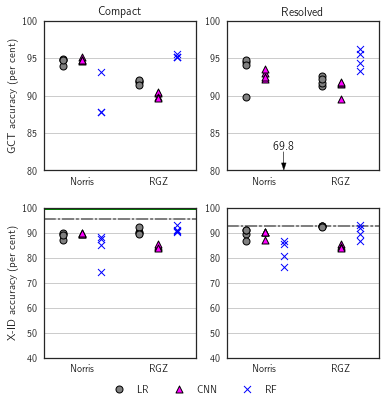

In [5]:
fig, ((compact_ba, resolved_ba), (compact_xid, resolved_xid)) = plt.subplots(2, 2, figsize=(6, 6))

markers = {'LogisticRegression': 'o', 'CNN': '^', 'RandomForestClassifier': 'x'}
colours = {'LogisticRegression': 'grey', 'CNN': 'magenta', 'RandomForestClassifier': 'blue'}

handles = {}

for l, labeller in enumerate(['Norris', 'RGZ']):
    if labeller == 'RGZ' and field == 'cdfs':
        # Labels
        accs = labeller_classifier_to_accuracies[labeller, 'Label', 'Resolved']
        resolved_xid.scatter([l * 4 + c + 1] * 4, accs,
                             c='orange', marker='s', zorder=2,
                             linewidth=1, edgecolor='k')
        accs = labeller_classifier_to_accuracies[labeller, 'Label', 'Compact']
        handles[3] = compact_xid.scatter([l * 4 + c + 1] * 4, accs,
                                                 c='orange', marker='s', zorder=2,
                                                 linewidth=1, edgecolor='k')

    for c, classifier in enumerate(['LogisticRegression', 'CNN', 'RandomForestClassifier']):
        accs = labeller_classifier_to_accuracies[labeller, classifier, 'Compact']
        handles[c] = compact_xid.scatter([l * 4 + c] * 4, accs,
                                         c=colours[classifier], marker=markers[classifier], zorder=2,
                                         linewidth=1, edgecolor='k')
        accs = labeller_classifier_to_accuracies[labeller, classifier, 'Resolved']
        resolved_xid.scatter([l * 4 + c] * 4, accs,
                             c=colours[classifier], marker=markers[classifier], zorder=2,
                             linewidth=1, edgecolor='k')
        compact_ba.scatter([l * 4 + c] * 4, bas[labeller][nnn[classifier]]['RGZ & Norris & compact'],
                           c=colours[classifier], marker=markers[classifier],
                           linewidth=1, edgecolor='k')
        resolved_ba.scatter([l * 4 + c] * 4, bas[labeller][nnn[classifier]]['RGZ & Norris & resolved'],
                            c=colours[classifier], marker=markers[classifier],
                            linewidth=1, edgecolor='k')

        if field == 'cdfs':
            xlim = 8
            rgz_tick = 5.5
        else:
            xlim = 7
            rgz_tick = 5
    
        nn_accs = labeller_classifier_to_accuracies['Norris', 'NearestNeighbour', 'Compact']
        compact_xid.fill_between([-1, 10], [numpy.mean(nn_accs) - numpy.std(nn_accs)] * 2,
                                 [numpy.mean(nn_accs) + numpy.std(nn_accs)] * 2, color='grey', alpha=0.05,
                                 edgecolor='grey', linestyle='-.', linewidth=2)
        compact_xid.axhline(numpy.mean(nn_accs), color='grey', linestyle='-.', zorder=1)
        nn_accs = labeller_classifier_to_accuracies['Norris', 'NearestNeighbour', 'Resolved']
        resolved_xid.fill_between([-1, 10], [numpy.mean(nn_accs) - numpy.std(nn_accs)] * 2,
                                 [numpy.mean(nn_accs) + numpy.std(nn_accs)] * 2, color='grey', alpha=0.05,
                                  edgecolor='grey', linestyle='-.', linewidth=2)
        resolved_xid.axhline(numpy.mean(nn_accs), color='grey', linestyle='-.', zorder=1)

        nn_accs = labeller_classifier_to_accuracies['Norris', 'Groundtruth', 'Resolved']
        resolved_xid.fill_between([-1, 10], [numpy.mean(nn_accs) - numpy.std(nn_accs)] * 2,
                                 [numpy.mean(nn_accs) + numpy.std(nn_accs)] * 2, color='green', alpha=0.05,
                                  edgecolor='green', linewidth=2)
        resolved_xid.axhline(numpy.mean(nn_accs), color='green', zorder=1)
        nn_accs = labeller_classifier_to_accuracies['Norris', 'Groundtruth', 'Compact']
        compact_xid.fill_between([-1, 10], [numpy.mean(nn_accs) - numpy.std(nn_accs)] * 2,
                                 [numpy.mean(nn_accs) + numpy.std(nn_accs)] * 2, color='green', alpha=0.05,
                                  edgecolor='green', linewidth=2)
        compact_xid.axhline(numpy.mean(nn_accs), color='green', zorder=1)
        nn_accs = labeller_classifier_to_accuracies['Norris', 'Random', 'Resolved']
        resolved_xid.fill_between([-1, 10], [numpy.mean(nn_accs) - numpy.std(nn_accs)] * 2,
                                 [numpy.mean(nn_accs) + numpy.std(nn_accs)] * 2, color='blue', alpha=0.05,
                                  edgecolor='blue', linestyle='-.', linewidth=2)
        resolved_xid.axhline(numpy.mean(nn_accs), color='blue', linestyle='-.', zorder=1)
        resolved_xid.set_xlim((-1, xlim))
        compact_xid.set_xlim((-1, xlim))
        resolved_ba.set_xlim((-1, 7))
        compact_ba.set_xlim((-1, 7))
        
        
        if c == 2 and l == 0 and field == 'elais':
            acc = numpy.mean(bas[labeller][nnn[classifier]]['RGZ & Norris & resolved'])
            resolved_ba.annotate('{:.1%}'.format(acc), (l * 4 + c, 0.825), ha='center', va='bottom')
            resolved_ba.arrow(2, 0.825, 0, -0.015, head_width=0.25, head_length=0.01, ec='k', fc='k')

compact_ba.set_ylabel('GCT accuracy (per cent)')
# resolved_ba.set_ylabel('Balanced accuracy (per cent)')
resolved_xid.yaxis.set_label_position('right')
compact_xid.set_ylabel('X-ID accuracy (per cent)')
resolved_ba.yaxis.set_label_position('right')
# resolved_xid.set_ylabel('Accuracy (per cent)')
compact_ba.grid(axis='y')
compact_ba.set_ylim((0.80, 1.0))
resolved_ba.grid(axis='y')
resolved_ba.set_ylim((0.80, 1.0))
compact_xid.grid(axis='y')
compact_xid.set_ylim((0.40, 1.0))
resolved_xid.grid(axis='y')
resolved_xid.set_ylim((0.40, 1.0))
compact_ba.set_title('Compact')
resolved_ba.set_title('Resolved')
compact_ba.set_yticks(numpy.arange(0.8, 1.01, 0.05))
resolved_ba.set_yticks(numpy.arange(0.8, 1.01, 0.05))

# Change all these to percentages.
for ax in [compact_ba, resolved_ba, compact_xid, resolved_xid]:
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    ax.set_xticks([1, rgz_tick])
    ax.set_xticklabels(['Norris', 'RGZ'])

if field == 'cdfs':
    plt.figlegend([handles[j] for j in sorted(handles)], ['LR', 'CNN', 'RF', 'Labels'],
                  'lower center', ncol=4, fontsize=10)
else:
    plt.figlegend([handles[j] for j in sorted(handles)], ['LR', 'CNN', 'RF'],
                  'lower center', ncol=3, fontsize=10)
plt.subplots_adjust(bottom=0.1, hspace=0.25)

plt.savefig('/Users/alger/repos/crowdastro-projects/ATLAS-CDFS/images/{}-grid-new.pdf'.format(field))

In [6]:
handles

{0: <matplotlib.collections.PathCollection at 0x119f43e80>,
 1: <matplotlib.collections.PathCollection at 0x116c18ef0>,
 2: <matplotlib.collections.PathCollection at 0x119f9aac8>}

In [7]:
accs = {'Compact': {}, 'Resolved': {}, 'All': {}}
stdevs = {'Compact': {}, 'Resolved': {}, 'All': {}}

for labeller in ['Norris', 'RGZ']:
    for classifier in ['Label', 'Groundtruth', 'LogisticRegression', 'CNN', 'RandomForestClassifier', 'NearestNeighbour', 'Random']:
        for ds in ['Compact', 'Resolved', 'All']:
            try:
                acc = labeller_classifier_to_accuracy[labeller, classifier, ds]
                accs[ds][labeller, classifier] = acc
                stdev = labeller_classifier_to_stdev[labeller, classifier, ds]
                stdevs[ds][labeller, classifier] = stdev
            except KeyError:
                continue

In [18]:
ba_accs = {'Compact': {}, 'Resolved': {}, 'All': {}}
ba_stdevs = {'Compact': {}, 'Resolved': {}, 'All': {}}
for labeller in ['Norris', 'RGZ']:
    for classifier in ['LogisticRegression', 'CNN', 'RandomForestClassifier']:
        for ds in ['RGZ & Norris & compact', 'RGZ & Norris & resolved', 'RGZ & Norris']:
            try:
                acc = numpy.mean(bas[labeller][nnn[classifier]][ds])
                ba_accs[titlemap[ds]][labeller, classifier] = acc
                stdev = numpy.std(bas[labeller][nnn[classifier]][ds])
                ba_stdevs[titlemap[ds]][labeller, classifier] = stdev
            except KeyError:
                continue
                
bas['Norris'][nnn['LogisticRegression']]

{'RGZ': [0, 0, 0, 0],
 'RGZ & Norris': [0, 0, 0, 0],
 'RGZ & Norris & compact': [0.94763341061605022,
  0.94884039201188863,
  0.9397525320902812,
  0.94785252792827634],
 'RGZ & Norris & resolved': [0.9450958117990389,
  0.9473298290884965,
  0.9403217474544443,
  0.89803333031383969],
 'RGZ & compact': [0.92869751283488844,
  0.92920062576966478,
  0.92993020073104393,
  0.92552092386713902],
 'RGZ & resolved': [0.94340163101623919,
  0.94486690153431085,
  0.93598346949617706,
  0.9071273108307607]}

In [8]:
print('\\hline')
print('Labeller & Classifier & Mean `Compact\' accuracy & Mean `Resolved\' accuracy & Mean `All\' accuracy\\\\')
print(' &  & (per cent) & (per cent) & (per cent)\\\\')
print('\\hline')
for labeller in ['Norris', 'RGZ']:
    for classifier in ['Label', 'Groundtruth', 'LogisticRegression', 'CNN', 'RandomForestClassifier', 'NearestNeighbour', 'Random']:
        try:
            print('{} & {} & ${:.1f} \\pm {:.1f}$ & ${:.1f} \\pm {:.1f}$ & ${:.1f} \\pm {:.1f}$\\\\'.format(
                labeller, classifier,
                100 * accs['Compact'][labeller, classifier], 100 * stdevs['Compact'][labeller, classifier],
                100 * accs['Resolved'][labeller, classifier], 100 * stdevs['Resolved'][labeller, classifier],
                100 * accs['All'][labeller, classifier], 100 * stdevs['All'][labeller, classifier]))
        except KeyError:
            continue
print('\\hline')

\hline
Labeller & Classifier & Mean `Compact' accuracy & Mean `Resolved' accuracy & Mean `All' accuracy\\
 &  & (per cent) & (per cent) & (per cent)\\
\hline
Norris & Groundtruth & $99.6 \pm 0.0$ & $99.8 \pm 0.0$ & $99.6 \pm 0.0$\\
Norris & LogisticRegression & $89.0 \pm 1.1$ & $89.7 \pm 1.8$ & $94.4 \pm 0.9$\\
Norris & CNN & $89.7 \pm 0.3$ & $89.4 \pm 1.4$ & $94.3 \pm 0.7$\\
Norris & RandomForestClassifier & $83.8 \pm 5.6$ & $82.3 \pm 4.1$ & $90.6 \pm 2.1$\\
Norris & NearestNeighbour & $95.5 \pm 0.0$ & $92.8 \pm 0.0$ & $95.5 \pm 0.0$\\
Norris & Random & $61.9 \pm 1.1$ & $26.6 \pm 2.1$ & $61.9 \pm 1.1$\\
RGZ & LogisticRegression & $90.5 \pm 1.0$ & $92.7 \pm 0.2$ & $95.9 \pm 0.1$\\
RGZ & CNN & $84.6 \pm 0.6$ & $84.6 \pm 0.6$ & $91.8 \pm 0.3$\\
RGZ & RandomForestClassifier & $91.3 \pm 1.0$ & $90.3 \pm 2.4$ & $94.7 \pm 1.2$\\
\hline


In [9]:
labeller_classifier_to_accuracies

defaultdict(list,
            {('Norris', 'CNN', 'All'): [0.9474708171206225,
              0.9464980544747081,
              0.9299610894941635,
              0.9464980544747081],
             ('Norris', 'CNN', 'Compact'): [0.8984375,
              0.89453125,
              0.89453125,
              0.900390625],
             ('Norris', 'CNN', 'Resolved'): [0.9035916824196597,
              0.9017013232514177,
              0.8695652173913043,
              0.9017013232514177],
             ('Norris', 'Groundtruth', 'All'): [0.9961089494163424,
              0.9961089494163424,
              0.9961089494163424,
              0.9961089494163424],
             ('Norris', 'Groundtruth', 'Compact'): [0.9961089494163424,
              0.9961089494163424,
              0.9961089494163424,
              0.9961089494163424],
             ('Norris', 'Groundtruth', 'Resolved'): [0.998109640831758,
              0.998109640831758,
              0.998109640831758,
              0.998109640831758]

In [27]:
for i in pipeline.unserialise_predictions(
        pipeline.WORKING_DIR + 'CNN_norris_{}_predictions'.format(field)):
    print(i.dataset_name)

OSError: Unable to open file (Unable to open file: name = '/users/alger/data/crowdastro/atlas-ml/lr_norris_elais_predictions_0_rgz & norris & compact.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)